# Sentiment Analysis with RNN Classifier
We will develop three different architetures of RNNs/MLPs sentiment classifiers for a movie review dataset and then we will predict the number of positive and negative reviews based on a test set. Also, we will use the *fasttext embeddings* in the training phase. Our three models are: 
* **BiGRU + MPL** 
* **BiLSTM + Linear self-attention + MLP**
* **BiLSTM + Deep self-attention + MLP**  

Then, we will calculate the precision, recall, F1, precision-recall AUC scores and their learning curves. 
### 4th Assignment


* Veloudi Anthi, P3352101
* Giannopoulos Panagiotis, P3352102
* Lazaridou Styliani, P3352109 
* Orfanoudakis Christos, P3352113

**Install required packages**

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install kaggle
!pip install --upgrade tensorflow
!pip install keras-self-attention
! pip install fasttext

**Check assigned GPU**

In [ ]:
!nvidia-smi

Fri Jun 17 16:12:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Dataset**
For the scope of our analysis we use the IMDB Dataset of 50K Movie Reviews from Kaggle. <br>
* https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

IMDB dataset has 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. The dataset provides a set of 25,000 positive movie reviews and 25,000 negative movie reviews. So, we can predict the number of positive and negative reviews using either classification or deep learning algorithms. 

#### **Download and import the dataset**

In [ ]:
#Mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Configure Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

#Move to Kaggle directory
%cd /content/drive/My Drive/Kaggle/

#Download Dataset
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

**Import the dataset**

In [ ]:
import pandas as pd
import numpy as np

#Importing the dataset
imdb_data=pd.read_csv('/content/drive/My Drive/Kaggle/IMDB Dataset.csv', encoding='utf-8')
print("Dimensions of the dataset: ", imdb_data.shape, '\n')
imdb_data.head(10)

Dimensions of the dataset:  (50000, 2) 



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


####  **Preprocess dataset**
We begin the cleaning by dropping the duplicate values, then we clean the text from HTML marks and others pecularities. Then we tokenize the dataset and lemmatize it.  



**Drop duplicate values**

In [ ]:
#Drop duplicate values
imdb_data = imdb_data.drop_duplicates(subset = ['review'])

#Sentiment count
imdb_data['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

**Cleaning the dataset**

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
import re


# Copy and create the new dataset
imdb_data_new = imdb_data[['review','sentiment']].copy()

#Remove html noise (like <br />)
imdb_data_new['review'] = [re.sub(r'<.*?>', ' ', str(x)) for x in imdb_data_new['review']]

#Remove non-word (special) characters such as punctuation, numbers etc
imdb_data_new['review'] = [re.sub(r'\W', ' ', str(x)) for x in imdb_data_new['review']]

#Remove all single characters
imdb_data_new['review'] = [re.sub(r'\s+[a-zA-Z]\s+', ' ', str(x)) for x in imdb_data_new['review']]

#Substitute multiple spaces with single space
imdb_data_new['review'] = [re.sub(r'\s+', ' ', str(x), flags=re.I) for x in imdb_data_new['review']]

#Convert to lowercase
imdb_data_new['review'] = imdb_data_new['review'].str.lower()

**Tokenize the sentences and lemmatize the words**

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

imdb_data_new['review'] = imdb_data_new.review.apply(lemmatize_text)

### **Split dataset**
We split the dataset in 
* Train (70%)
* Test (30%) 

We separate the data as training set and test set to increase reliability. We will train our models with the training dataset and use the test dataset to measure our accuracy.

In [ ]:
from sklearn.model_selection import train_test_split  

x_train, x_test, y_train, y_test = train_test_split(imdb_data_new.review, \
                                                    imdb_data_new.sentiment, test_size=0.3, random_state=155)

In [ ]:
print('Training set    : ', len(x_train))
print('Test set        : ', len(x_test))

Training set    :  34707
Test set        :  14875


### **Tokenize and Padding**

In this step, we use the Keras tokenizer to tokenize the train and the test dataset, convert text (sequence of words) to sequence of indexes and PAD the sequences. We will suppose a **vocabulary size of 80000** and a **max sequence lenght of 150 words** to perform the padding. 

Later we will use those data to initialize the embedding matrix with the fasttext pre-trained embendings.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 80000
MAX_SEQUENCE_LENGTH = 150

# Keras tokenizer uses \s for separating tokens
tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token = '__UNK__')
tokenizer.fit_on_texts([" ".join(x) for x in x_train])

train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_train])
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_test])

# Padding
train_data = pad_sequences(train_seqs, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
test_data = pad_sequences(test_seqs, maxlen = MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
print(train_data.shape)

(34707, 150)


In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 79368 unique tokens.


## **Word embedings**

In this project we will use fasttext embeddings, as word embeddings. Those pre-trained word vectors have dimension 300.

#### **Download and unzip fasttext embeddings**

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

#### **Load fasttext embeddings**

To load fasttext pre-trained embeddings more efficiently, we can read only once the embeddings file and save:

1. A 2D np-array for the embedding vectors
2. A dictionary that maps each word to the row index of its embedding on the 2D np-array

In [ ]:
import pickle
import numpy as np

idx = 0
vocab = {}
with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 2
            dim = int(line[1])
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            vocab["__UNK__"] = 1
            idx = 2
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb
                idx+=1
            else:
                continue

    pickle.dump(vocab,open("/content/drive/My Drive/fasttext_voc.pkl" ,'wb'))
    np.save("/content/drive/My Drive/fasttext.npy",vecs)
   
    # Free ram
    vecs = None
    vocab = None
    emb = None

**Load embeddings np-array and mapping dictionary**



In [ ]:
import pickle
import numpy as np

fasttext_embed = np.load("/content/drive/MyDrive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/drive/MyDrive/fasttext_voc.pkl", 'rb'))

In [ ]:
fasttext_embed.shape

(2000002, 300)

#### **Initialize embedding matrix with fasttext pre-trained embedings**

In [ ]:
EMBEDDING_DIM = fasttext_embed.shape[1]

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

## **Functions/Classes**

In this step we will define all the functions and classes that we will use in our calculations.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

**Function for evalution the models**


In [ ]:
def evaluation(model, X, y):
  pred = model.predict(X)
  predictions_test = np.argmax(pred, -1)
  report_test = classification_report(y, predictions_test, target_names=['Negative','Positive'], digits = 4)
  print(report_test)
  print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y, pred[:, 0])))
  print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y, pred[:, 1])),'\n')
  print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y, np.argmax(pred, -1))),'\n')

**Function for convert labels to 1-hot vectors**

In [ ]:
def encode_1_hot(y_set):
  # integer encode
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(y_set)

  # binary encode
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  return(onehot_encoded)

**Function for plot graphs**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_hist(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'dev'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'dev'], loc='upper right')
  plt.show()

**Class for keep metrics in each epoch end**

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np
import os


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

**Class for custom keras layer for deep self-attention over RNNs output states**

In [ ]:
"""
Implemented by slightly changed SeqWeightedAttention class from keras-self-attention library
https://github.com/CyberZHG/keras-self-attention/blob/master/keras_self_attention/seq_weighted_attention.py
"""

from tensorflow import keras
from tensorflow.keras import backend as K


class DeepSeqWeightedAttention(keras.layers.Layer):
    """
      h1_t = tanh(W_h1*X + b_h1)
      a_t = Softmax(W_h2*h1_t + b_h2)
      Σ = Sum(a_t*X)   
    """

    def __init__(self, use_bias=True, return_attention=False, **kwargs):
        super(DeepSeqWeightedAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.use_bias = use_bias
        self.return_attention = return_attention
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None

    def get_config(self):
        config = {
            'use_bias': self.use_bias,
            'return_attention': self.return_attention,
        }
        base_config = super(DeepSeqWeightedAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
      #mlp with one hiddel layer
        self.W1 = self.add_weight(shape=(int(input_shape[2]), int(input_shape[2])),
                                 name='{}_Wh1'.format(self.name),
                                 initializer=keras.initializers.get('uniform'))
        self.W2 = self.add_weight(shape=(int(input_shape[2]), 1),
                                 name='{}_Wh2'.format(self.name),
                                 initializer=keras.initializers.get('uniform'))
        if self.use_bias:
            self.b1 = self.add_weight(shape=(int(input_shape[2]),),
                                     name='{}_b1'.format(self.name),
                                     initializer=keras.initializers.get('zeros'))
            self.b2 = self.add_weight(shape=(1,),
                                     name='{}_b2'.format(self.name),
                                     initializer=keras.initializers.get('zeros'))
        super(DeepSeqWeightedAttention, self).build(input_shape)

    def call(self, x, mask=None):
        h_t = K.dot(x, self.W1)
        if self.use_bias:
            h_t += self.b1
        h_t = K.tanh(h_t)
        logits = K.dot(h_t, self.W2)
        if self.use_bias:
            logits += self.b2
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            logits -= 10000.0 * (1.0 - mask)
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        #weighted sum of the hidden states
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return input_shape[0], output_len

    def compute_mask(self, _, input_mask=None):
        if self.return_attention:
            return [None, None]
        return None

    @staticmethod
    def get_custom_objects():
        return {'DeepSeqWeightedAttention': DeepSeqWeightedAttention}

## **RNN classifiers**
We  develop three different architetures of RNNs/MLPs sentiment classifiers. Our three models are: 
* **BiGRU + MPL** 
* **BiLSTM + Linear self-attention + MLP**
* **BiLSTM + Deep self-attention + MLP**

#### **BiGRU + MLP model**

In [ ]:
y_train_1_hot = encode_1_hot(y_train)
y_test_1_hot = encode_1_hot(y_test)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam

GRU_SIZE = 300
DENSE = 1000

with tf.device('/device:GPU:0'):

  # create empty sequential model
  model = Sequential()
  # add an embedding layer
  model.add(Embedding(MAX_WORDS+2, EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
  # Use 0.33 dropout probabillity
  model.add(Dropout(0.33))
  # add a bidirectional gru layer with 0.33 variational (recurrent) dropout 
  model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=False, recurrent_dropout = 0.33)))
  # add a hidden MLP layer
  model.add(Dropout(0.33))
  model.add(Dense(DENSE, activation='relu' ))
  # add the output MLP layer
  model.add(Dropout(0.33))
  model.add(Dense(len(y_train_1_hot[0]), activation='softmax'))

  print(model.summary())
  model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=["accuracy"])

  if not os.path.exists('/content/drive/My Drive/checkpoints'):
    os.makedirs('/content/drive/My Drive/checkpoints')

  checkpoint = ModelCheckpoint('/content/drive/My Drive/checkpoints/BiGRU_MLP_model',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=False)

  history = model.fit(train_data, y_train_1_hot,
                validation_data=(test_data, y_test_1_hot),
                batch_size=1024,
                epochs=10,
                shuffle=True,
                callbacks=[Metrics(valid_data=(test_data, y_test_1_hot)),
                checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          24000600  
                                                                 
 dropout (Dropout)           (None, 150, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1083600   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 600)               0         
                                                                 
 dense (Dense)               (None, 1000)              601000    
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0         
                                                        

34/34 [==============================] - 145s 4s/step - loss: 0.6187 - accuracy: 0.6516 - val_loss: 0.5725 - val_accuracy: 0.7203 - val_f1: 0.7141 - val_recall: 0.7203 - val_precision: 0.7433
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.7344 — val_f1: 0.684660 — val_precision: 0.767410 — val_recall: 0.704202

Epoch 2: val_f1 did not improve from 0.71406
34/34 [==============================] - 134s 4s/step - loss: 0.5557 - accuracy: 0.7344 - val_loss: 0.5602 - val_accuracy: 0.7042 - val_f1: 0.6847 - val_recall: 0.7042 - val_precision: 0.7674
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.7700 — val_f1: 0.823295 — val_precision: 0.824529 — val_recall: 0.823395

Epoch 3: val_f1 improved from 0.71406 to 0.82329, saving model to /content/drive/My Drive/checkpoints/BiGRU_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


34/34 [==============================] - 138s 4s/step - loss: 0.4797 - accuracy: 0.7700 - val_loss: 0.3921 - val_accuracy: 0.8234 - val_f1: 0.8233 - val_recall: 0.8234 - val_precision: 0.8245
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8085 — val_f1: 0.832569 — val_precision: 0.833705 — val_recall: 0.832739

Epoch 4: val_f1 improved from 0.82329 to 0.83257, saving model to /content/drive/My Drive/checkpoints/BiGRU_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


34/34 [==============================] - 141s 4s/step - loss: 0.4210 - accuracy: 0.8085 - val_loss: 0.3729 - val_accuracy: 0.8327 - val_f1: 0.8326 - val_recall: 0.8327 - val_precision: 0.8337
Epoch 5/10
34/34 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.7933 — val_f1: 0.824425 — val_precision: 0.831869 — val_recall: 0.825412

Epoch 5: val_f1 did not improve from 0.83257
34/34 [==============================] - 126s 4s/step - loss: 0.4488 - accuracy: 0.7933 - val_loss: 0.3857 - val_accuracy: 0.8254 - val_f1: 0.8244 - val_recall: 0.8254 - val_precision: 0.8319
Epoch 6/10
34/34 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8224 — val_f1: 0.845487 — val_precision: 0.845995 — val_recall: 0.845513

Epoch 6: val_f1 improved from 0.83257 to 0.84549, saving model to /content/drive/My Drive/checkpoints/BiGRU_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


34/34 [==============================] - 118s 4s/step - loss: 0.3952 - accuracy: 0.8224 - val_loss: 0.3548 - val_accuracy: 0.8455 - val_f1: 0.8455 - val_recall: 0.8455 - val_precision: 0.8460
Epoch 7/10
34/34 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.8333 — val_f1: 0.849201 — val_precision: 0.849718 — val_recall: 0.849277

Epoch 7: val_f1 improved from 0.84549 to 0.84920, saving model to /content/drive/My Drive/checkpoints/BiGRU_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


34/34 [==============================] - 130s 4s/step - loss: 0.3750 - accuracy: 0.8333 - val_loss: 0.3408 - val_accuracy: 0.8493 - val_f1: 0.8492 - val_recall: 0.8493 - val_precision: 0.8497
Epoch 8/10
34/34 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.8362 — val_f1: 0.848315 — val_precision: 0.850713 — val_recall: 0.848605

Epoch 8: val_f1 did not improve from 0.84920
34/34 [==============================] - 110s 3s/step - loss: 0.3683 - accuracy: 0.8362 - val_loss: 0.3437 - val_accuracy: 0.8486 - val_f1: 0.8483 - val_recall: 0.8486 - val_precision: 0.8507
Epoch 9/10
34/34 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8419 — val_f1: 0.860505 — val_precision: 0.860507 — val_recall: 0.860504

Epoch 9: val_f1 improved from 0.84920 to 0.86051, saving model to /content/drive/My Drive/checkpoints/BiGRU_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_MLP_model/assets


34/34 [==============================] - 125s 4s/step - loss: 0.3529 - accuracy: 0.8419 - val_loss: 0.3244 - val_accuracy: 0.8605 - val_f1: 0.8605 - val_recall: 0.8605 - val_precision: 0.8605
Epoch 10/10
34/34 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.8483 — val_f1: 0.858854 — val_precision: 0.859083 — val_recall: 0.858891

Epoch 10: val_f1 did not improve from 0.86051
34/34 [==============================] - 116s 3s/step - loss: 0.3441 - accuracy: 0.8483 - val_loss: 0.3224 - val_accuracy: 0.8589 - val_f1: 0.8589 - val_recall: 0.8589 - val_precision: 0.8591


##### **Plot Training History**

Visualize model's training history. Plot the model accuracy and model loss per epoch.

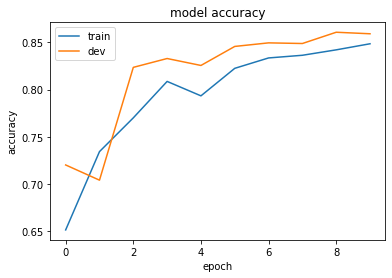

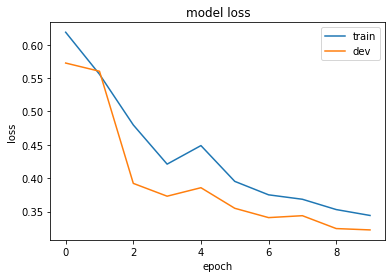

In [ ]:
plot_hist(history)

##### **Evaluation**

Evaluate performance of **BiGRU + MLP model** on training and testing data.

In [ ]:
print("\n----------------------Train Data----------------------")
evaluation(model, train_data, np.where(y_train == 'negative',0,1))
print("\n----------------------Test Data----------------------")
evaluation(model, test_data, np.where(y_test == 'negative',0,1))


----------------------Train Data----------------------
              precision    recall  f1-score   support

    Negative     0.8760    0.8540    0.8648     17324
    Positive     0.8580    0.8795    0.8686     17383

    accuracy                         0.8668     34707
   macro avg     0.8670    0.8667    0.8667     34707
weighted avg     0.8670    0.8668    0.8667     34707

PR-AUC score Negative: 0.0568
PR-AUC score Positive: 0.9432 

Macro average PR-AUC score: 0.8150 


----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative     0.8669    0.8451    0.8559      7374
    Positive     0.8514    0.8724    0.8618      7501

    accuracy                         0.8589     14875
   macro avg     0.8591    0.8588    0.8588     14875
weighted avg     0.8591    0.8589    0.8589     14875

PR-AUC score Negative: 0.0632
PR-AUC score Positive: 0.9368 

Macro average PR-AUC score: 0.8071 



#### **BiLSTM + linear self-attention + MLP model**


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqWeightedAttention


LSTM_SIZE = 300
DENSE = 1000

with tf.device('/device:GPU:0'):

  # create empty sequential model
  model2 = Sequential()
  # add an embedding layer
  model2.add(Embedding(MAX_WORDS+2, EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
  # Use 0.33 dropout probabillity
  model2.add(Dropout(0.33))
  # add a bidirectional LSTM layer with 0.33 variational (recurrent) dropout 
  model2.add(Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout = 0.33)))
  # dropout layer
  model2.add(Dropout(0.33))
  # Add linear self-attention layer
  model2.add(SeqWeightedAttention())  # sum(softmax(XW + b) * X)
  # add a hidden MLP layer
  model2.add(Dense(DENSE, activation='relu' ))
  # dropout layer
  model2.add(Dropout(0.33))
  # add the output MLP layer
  model2.add(Dense(len(y_train_1_hot[0]), activation='softmax'))

  print(model2.summary())
  model2.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=["accuracy"])

  if not os.path.exists('/content/drive/My Drive/checkpoints'):
    os.makedirs('/content/drive/My Drive/checkpoints')

  checkpoint = ModelCheckpoint('/content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=False)

  history2 = model2.fit(train_data, y_train_1_hot,
                validation_data=(test_data, y_test_1_hot),
                batch_size=1024,
                epochs=10,
                shuffle=True,
                callbacks=[Metrics(valid_data=(test_data, y_test_1_hot)),
                checkpoint])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 300)          24000600  
                                                                 
 dropout_3 (Dropout)         (None, 150, 300)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 600)         1083600   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 150, 600)          0         
                                                                 
 seq_weighted_attention (Seq  (None, 600)              601       
 WeightedAttention)                                              
                                                                 
 dense_2 (Dense)             (None, 1000)             

INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 146s 4s/step - loss: 0.5998 - accuracy: 0.6632 - val_loss: 0.4680 - val_accuracy: 0.7786 - val_f1: 0.7776 - val_recall: 0.7786 - val_precision: 0.7825
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.4548 - accuracy: 0.7857 — val_f1: 0.811694 — val_precision: 0.820107 — val_recall: 0.812639

Epoch 2: val_f1 improved from 0.77763 to 0.81169, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 141s 4s/step - loss: 0.4548 - accuracy: 0.7857 - val_loss: 0.4157 - val_accuracy: 0.8126 - val_f1: 0.8117 - val_recall: 0.8126 - val_precision: 0.8201
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8109 — val_f1: 0.841929 — val_precision: 0.842492 — val_recall: 0.842017

Epoch 3: val_f1 improved from 0.81169 to 0.84193, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 127s 4s/step - loss: 0.4115 - accuracy: 0.8109 - val_loss: 0.3642 - val_accuracy: 0.8420 - val_f1: 0.8419 - val_recall: 0.8420 - val_precision: 0.8425
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8329 — val_f1: 0.853210 — val_precision: 0.855202 — val_recall: 0.853445

Epoch 4: val_f1 improved from 0.84193 to 0.85321, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 146s 4s/step - loss: 0.3708 - accuracy: 0.8329 - val_loss: 0.3366 - val_accuracy: 0.8534 - val_f1: 0.8532 - val_recall: 0.8534 - val_precision: 0.8552
Epoch 5/10
34/34 [==============================] - ETA: 0s - loss: 0.3526 - accuracy: 0.8448 — val_f1: 0.867698 — val_precision: 0.867700 — val_recall: 0.867697

Epoch 5: val_f1 improved from 0.85321 to 0.86770, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 125s 4s/step - loss: 0.3526 - accuracy: 0.8448 - val_loss: 0.3148 - val_accuracy: 0.8677 - val_f1: 0.8677 - val_recall: 0.8677 - val_precision: 0.8677
Epoch 6/10
34/34 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8523 — val_f1: 0.866719 — val_precision: 0.869772 — val_recall: 0.867025

Epoch 6: val_f1 did not improve from 0.86770
34/34 [==============================] - 141s 4s/step - loss: 0.3386 - accuracy: 0.8523 - val_loss: 0.3136 - val_accuracy: 0.8670 - val_f1: 0.8667 - val_recall: 0.8670 - val_precision: 0.8698
Epoch 7/10
34/34 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8558 — val_f1: 0.875562 — val_precision: 0.876903 — val_recall: 0.875697

Epoch 7: val_f1 improved from 0.86770 to 0.87556, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets

INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 123s 4s/step - loss: 0.3288 - accuracy: 0.8558 - val_loss: 0.2991 - val_accuracy: 0.8757 - val_f1: 0.8756 - val_recall: 0.8757 - val_precision: 0.8769
Epoch 8/10
34/34 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8637 — val_f1: 0.878254 — val_precision: 0.878271 — val_recall: 0.878252

Epoch 8: val_f1 improved from 0.87556 to 0.87825, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 147s 4s/step - loss: 0.3164 - accuracy: 0.8637 - val_loss: 0.2879 - val_accuracy: 0.8783 - val_f1: 0.8783 - val_recall: 0.8783 - val_precision: 0.8783
Epoch 9/10
34/34 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8697 — val_f1: 0.881704 — val_precision: 0.882848 — val_recall: 0.881815

Epoch 9: val_f1 improved from 0.87825 to 0.88170, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 132s 4s/step - loss: 0.3058 - accuracy: 0.8697 - val_loss: 0.2861 - val_accuracy: 0.8818 - val_f1: 0.8817 - val_recall: 0.8818 - val_precision: 0.8828
Epoch 10/10
34/34 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8727 — val_f1: 0.873209 — val_precision: 0.879281 — val_recall: 0.873748

Epoch 10: val_f1 did not improve from 0.88170
34/34 [==============================] - 144s 4s/step - loss: 0.2973 - accuracy: 0.8727 - val_loss: 0.2895 - val_accuracy: 0.8737 - val_f1: 0.8732 - val_recall: 0.8737 - val_precision: 0.8793


##### **Plot Training History**
Visualize model's training history. Plot the model accuracy and model loss per epoch.

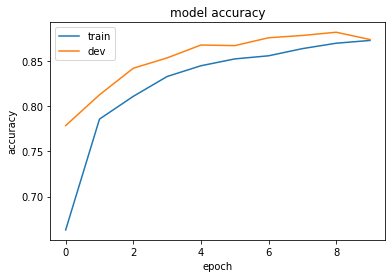

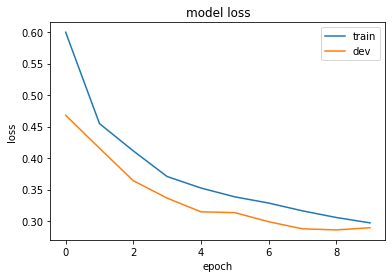

In [ ]:
plot_hist(history2)

 ##### **Evaluation**
 Evaluate performance of **BiLSTM + linear self-attention + MLP model** on training and testing data.

In [ ]:
print("\n----------------------Train Data----------------------")
evaluation(model2, train_data, np.where(y_train == 'negative',0,1))
print("\n----------------------Test Data----------------------")
evaluation(model2, test_data, np.where(y_test == 'negative',0,1))


----------------------Train Data----------------------
              precision    recall  f1-score   support

    Negative     0.9335    0.8133    0.8692     17324
    Positive     0.8351    0.9422    0.8854     17383

    accuracy                         0.8779     34707
   macro avg     0.8843    0.8778    0.8773     34707
weighted avg     0.8842    0.8779    0.8773     34707

PR-AUC score Negative: 0.0412
PR-AUC score Positive: 0.9588 

Macro average PR-AUC score: 0.8158 


----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative     0.9250    0.8111    0.8643      7374
    Positive     0.8343    0.9353    0.8820      7501

    accuracy                         0.8737     14875
   macro avg     0.8797    0.8732    0.8731     14875
weighted avg     0.8793    0.8737    0.8732     14875

PR-AUC score Negative: 0.0449
PR-AUC score Positive: 0.9551 

Macro average PR-AUC score: 0.8130 



#### **BiLSTM + deep self-attention + MLP model**

Create and train

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqWeightedAttention


LSTM_SIZE = 300
DENSE = 1000

with tf.device('/device:GPU:0'):

  # create empty sequential model
  model3 = Sequential()
  # add an embedding layer
  model3.add(Embedding(MAX_WORDS+2, EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
  # Use 0.33 dropout probabillity
  model3.add(Dropout(0.33))
  # add a bidirectional LSTM layer with 0.33 variational (recurrent) dropout 
  model3.add(Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout = 0.33)))
  # dropout layer
  model3.add(Dropout(0.33))
  # Add deep self-attention layer
  model3.add(DeepSeqWeightedAttention())
  # add a hidden MLP layer
  model3.add(Dense(DENSE, activation='relu' ))
  # dropout layer
  model3.add(Dropout(0.33))
  # add the output MLP layer
  model3.add(Dense(len(y_train_1_hot[0]), activation='softmax'))

  print(model3.summary())
  model3.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=["accuracy"])

  if not os.path.exists('/content/drive/My Drive/checkpoints'):
    os.makedirs('/content/drive/My Drive/checkpoints')

  checkpoint = ModelCheckpoint('/content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=False)

  history3 = model3.fit(train_data, y_train_1_hot,
                validation_data=(test_data, y_test_1_hot),
                batch_size=1024,
                epochs=10,
                shuffle=True,
                callbacks=[Metrics(valid_data=(test_data, y_test_1_hot)),
                checkpoint])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          24000600  
                                                                 
 dropout_6 (Dropout)         (None, 150, 300)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 600)         1083600   
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 150, 600)          0         
                                                                 
 deep_seq_weighted_attention  (None, 600)              361201    
  (DeepSeqWeightedAttention)                                     
                                                                 
 dense_4 (Dense)             (None, 1000)             

INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 137s 4s/step - loss: 0.5706 - accuracy: 0.6889 - val_loss: 0.4598 - val_accuracy: 0.7896 - val_f1: 0.7867 - val_recall: 0.7896 - val_precision: 0.8084
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.8173 — val_f1: 0.844141 — val_precision: 0.852193 — val_recall: 0.844840

Epoch 2: val_f1 improved from 0.78669 to 0.84414, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 137s 4s/step - loss: 0.4032 - accuracy: 0.8173 - val_loss: 0.3579 - val_accuracy: 0.8448 - val_f1: 0.8441 - val_recall: 0.8448 - val_precision: 0.8522
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.8424 — val_f1: 0.862261 — val_precision: 0.865992 — val_recall: 0.862521

Epoch 3: val_f1 improved from 0.84414 to 0.86226, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 146s 4s/step - loss: 0.3569 - accuracy: 0.8424 - val_loss: 0.3208 - val_accuracy: 0.8625 - val_f1: 0.8623 - val_recall: 0.8625 - val_precision: 0.8660
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.8547 — val_f1: 0.872533 — val_precision: 0.873872 — val_recall: 0.872672

Epoch 4: val_f1 improved from 0.86226 to 0.87253, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 149s 4s/step - loss: 0.3346 - accuracy: 0.8547 - val_loss: 0.2996 - val_accuracy: 0.8727 - val_f1: 0.8725 - val_recall: 0.8727 - val_precision: 0.8739
Epoch 5/10
34/34 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8598 — val_f1: 0.866258 — val_precision: 0.874183 — val_recall: 0.866824

Epoch 5: val_f1 did not improve from 0.87253
34/34 [==============================] - 140s 4s/step - loss: 0.3249 - accuracy: 0.8598 - val_loss: 0.3129 - val_accuracy: 0.8668 - val_f1: 0.8663 - val_recall: 0.8668 - val_precision: 0.8742
Epoch 6/10
34/34 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8624 — val_f1: 0.881919 — val_precision: 0.882163 — val_recall: 0.881950

Epoch 6: val_f1 improved from 0.87253 to 0.88192, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets

INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 127s 4s/step - loss: 0.3217 - accuracy: 0.8624 - val_loss: 0.2831 - val_accuracy: 0.8819 - val_f1: 0.8819 - val_recall: 0.8819 - val_precision: 0.8822
Epoch 7/10
34/34 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.8706 — val_f1: 0.887800 — val_precision: 0.887865 — val_recall: 0.887798

Epoch 7: val_f1 improved from 0.88192 to 0.88780, saving model to /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 156s 5s/step - loss: 0.3056 - accuracy: 0.8706 - val_loss: 0.2747 - val_accuracy: 0.8878 - val_f1: 0.8878 - val_recall: 0.8878 - val_precision: 0.8879
Epoch 8/10
34/34 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8723 — val_f1: 0.880433 — val_precision: 0.883974 — val_recall: 0.880739

Epoch 8: val_f1 did not improve from 0.88780
34/34 [==============================] - 132s 4s/step - loss: 0.2974 - accuracy: 0.8723 - val_loss: 0.2824 - val_accuracy: 0.8807 - val_f1: 0.8804 - val_recall: 0.8807 - val_precision: 0.8840
Epoch 9/10
34/34 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.8674 — val_f1: 0.885726 — val_precision: 0.888088 — val_recall: 0.885849

Epoch 9: val_f1 did not improve from 0.88780
34/34 [==============================] - 138s 4s/step - loss: 0.3062 - accuracy: 0.8674 - val_loss: 0.2755 - val_accuracy: 0.8858 - val_f1: 0.8857 - val_recall: 0.8858 - val_precision: 0.8881
Epoch 10

INFO:tensorflow:Assets written to: /content/drive/My Drive/checkpoints/BiGRU_linear_attention_MLP_model/assets


34/34 [==============================] - 140s 4s/step - loss: 0.2901 - accuracy: 0.8783 - val_loss: 0.2653 - val_accuracy: 0.8919 - val_f1: 0.8919 - val_recall: 0.8919 - val_precision: 0.8927


##### **Plot Training History**
Visualize model's training history. Plot the model accuracy and model loss per epoch.

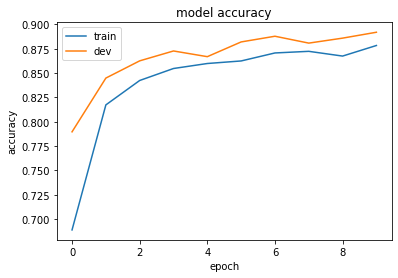

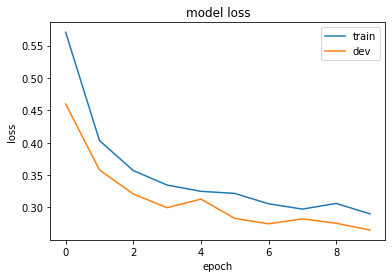

In [ ]:
plot_hist(history3)

 ##### **Evaluation**
 Evaluate performance of **BiLSTM + deep self-attention + MLP model** on training and testing data.

In [ ]:
print("\n----------------------Train Data----------------------")
evaluation(model3, train_data, np.where(y_train == 'negative',0,1))
print("\n----------------------Test Data----------------------")
evaluation(model3, test_data, np.where(y_test == 'negative',0,1))


----------------------Train Data----------------------
              precision    recall  f1-score   support

    Negative     0.8797    0.9121    0.8956     17324
    Positive     0.9090    0.8757    0.8921     17383

    accuracy                         0.8939     34707
   macro avg     0.8944    0.8939    0.8938     34707
weighted avg     0.8944    0.8939    0.8938     34707

PR-AUC score Negative: 0.0385
PR-AUC score Positive: 0.9615 

Macro average PR-AUC score: 0.8583 


----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative     0.8739    0.9138    0.8934      7374
    Positive     0.9112    0.8704    0.8904      7501

    accuracy                         0.8919     14875
   macro avg     0.8926    0.8921    0.8919     14875
weighted avg     0.8927    0.8919    0.8919     14875

PR-AUC score Negative: 0.0415
PR-AUC score Positive: 0.9585 

Macro average PR-AUC score: 0.8585 

